In [47]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import sklearn.cluster as cluster
from sklearn.ensemble import RandomForestClassifier

In [2]:
directory = 'C:/githubrepo/7331_Project/data/'
df_zg = pd.read_csv(directory + 'Diabetic_Cleaned.csv')
print("Done reading data.")

Done reading data.


In [3]:
df_zg_makehot = df_zg[["max_glu_serum", "A1Cresult", "insulin"]]
df_zg_ok = df_zg[["age", "gender", "diabetesMed"]]

In [4]:
#Make age ordinal
for i in range(0, 10):
    val = "[" + str(i*10) + "-" + str((i+1)*10) + ")"
    df_zg_ok.loc[df_zg_ok['age'] == val, 'age'] = i
df_zg_ok["age"] = df_zg_ok["age"].astype(int)
 
#Gender: 1 = Female, 0 = Male
df_zg_ok.gender[df_zg_ok.gender == 'Male'] = 0
df_zg_ok.gender[df_zg_ok.gender == 'Female'] = 1
df_zg_ok["gender"] = df_zg_ok["gender"].astype(object)

#diabetesMed: 1 = Yes, 0 = No
df_zg_ok.diabetesMed[df_zg_ok.diabetesMed == 'No'] = 0
df_zg_ok.diabetesMed[df_zg_ok.diabetesMed == 'Yes'] = 1
df_zg_ok["diabetesMed"] = df_zg_ok["diabetesMed"].astype(object)

In [5]:
df_zg_hot_x = pd.concat([df_zg_ok, pd.get_dummies(df_zg_makehot)], axis = 1)
df_zg_y = df_zg["readmitted_tf"]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df_zg_hot_x, df_zg_y, test_size = 0.8, random_state = 7)

#Print out the shapes of the train/valid/test sets
x_train.shape, x_test.shape

((20353, 15), (81413, 15))

In [10]:
scl = StandardScaler()
x_train = scl.fit_transform(x_train)
x_test = scl.transform(x_test)

# ALL Types of Clustering

#### Clustering functions

In [93]:
#https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html
#Runs the clusters and returns the scores
def do_clusters(data, algorithm, args, kwds, do_sil = False):
    alg = algorithm(*args, **kwds)
    labels = alg.fit_predict(data)
    
    #dist = kmeans.inertia_
    dbs = (metrics.davies_bouldin_score(data, labels)) #Smaller = Better
    chs = (metrics.calinski_harabasz_score(data, labels)) #Bigger = Better
    ss = 1
    if do_sil:
        ss = (metrics.silhouette_score(data, labels, metric='euclidean')) #Bigger=Better
    
    NUM_ESTIMATORS = 100
    NO_JOBS = 4
    RANDOM_STATE = 2000        
    rf_clf = RandomForestClassifier(random_state = RANDOM_STATE, criterion = 'gini', 
                                    n_estimators = NUM_ESTIMATORS, verbose = False, n_jobs = NO_JOBS)
    rf_clf.fit(data, labels)
    preds = rf_clf.predict(data)
    ba = metrics.balanced_accuracy_score(labels, preds)
    
    return [dbs, chs, ss, ba]

#Plots the metrics for the clusters
def plot_metrics(m_df, size_rng, do_sil = True):
    plt.plot(size_rng, m_df.DBS, marker = 'o')
    plt.xlabel('n_components')
    plt.ylabel('Davies Bouldin Score')
    plt.show()
    plt.plot(size_rng, m_df.CHS, marker = 'o')
    plt.xlabel('n_components')
    plt.ylabel('Calinski Harabasz Score')
    plt.show()
    if do_sil:
        plt.plot(size_rng, m_df.SS, marker = 'o')
        plt.xlabel('n_components')
        plt.ylabel('Silhouette Score')
        plt.show()
    plt.plot(size_rng, m_df.BA, marker = 'o')
    plt.xlabel('n_components')
    plt.ylabel('Balanced Accuracy')
    plt.show()
    #plt.xticks(np.arange(1, 20, 1)) 

## KMeans Clustering

DBS: 8, CHS: 11, SS: 8, ACC: X

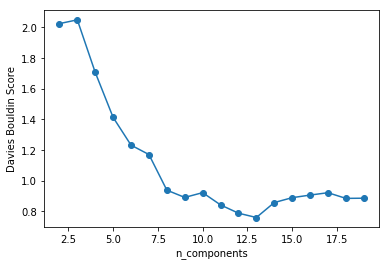

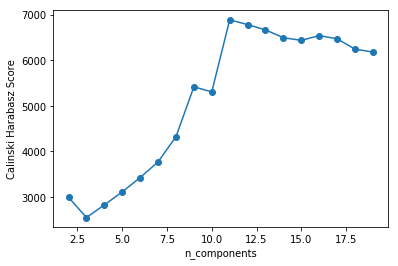

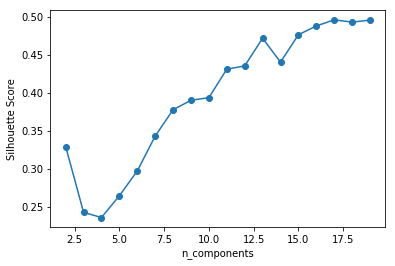

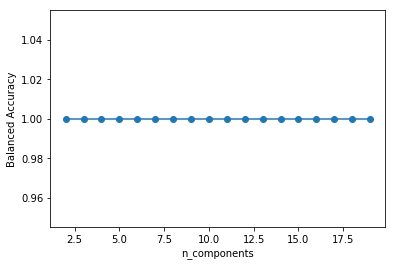

Wall time: 2min 36s


In [95]:
%%time
#Dataframe to hold the metrics
metric_df = pd.DataFrame(columns=['DBS', 'CHS', 'SS', 'BA'])
#Range for the number of clusters
size_rng = range(2,20)

for i in size_rng:
    metric_df.loc[len(metric_df), :] = do_clusters(x_train, cluster.KMeans, (), {'n_clusters':i}, True)

#Plots the metrics
plot_metrics(metric_df, size_rng)

## Agglomerative Clustering

DBS: 10, CHS: 11, SS: 2/10, ACC: X

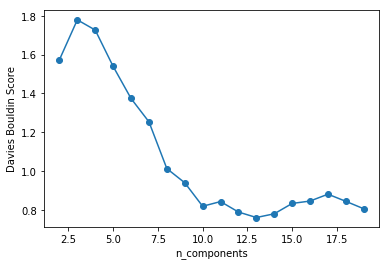

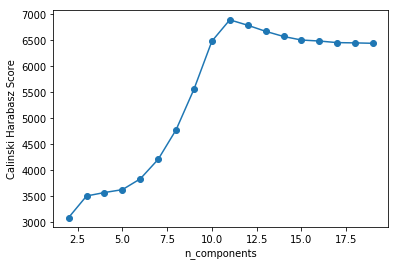

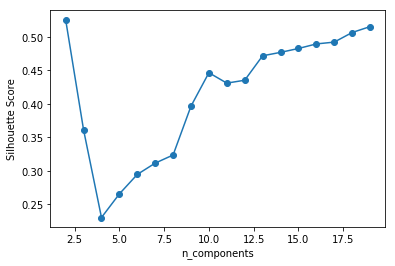

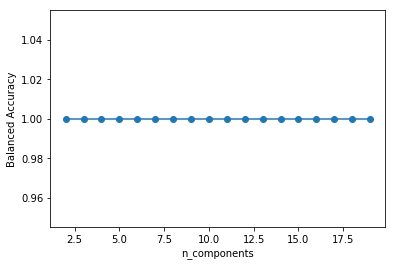

Wall time: 5min 35s


In [97]:
%%time
#Dataframe to hold the metrics
metric_df = pd.DataFrame(columns=['DBS', 'CHS', 'SS', 'BA'])
#Range for the number of clusters
size_rng = range(2,20)

for i in size_rng:
    metric_df.loc[len(metric_df), :] = do_clusters(x_train, cluster.AgglomerativeClustering, (),
                                                   {'n_clusters':i, 'linkage':'ward'}, True)

#Plots the metrics
plot_metrics(metric_df, size_rng)

## OPTICS

##### DBS: 26, CHS: 34, SS: 26, ACC: 26

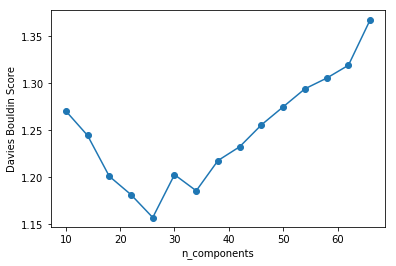

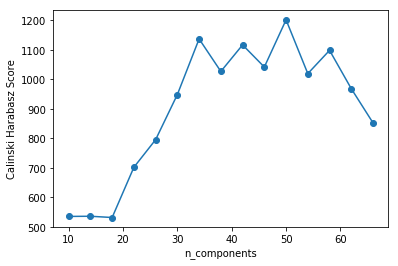

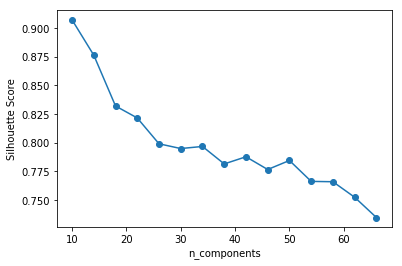

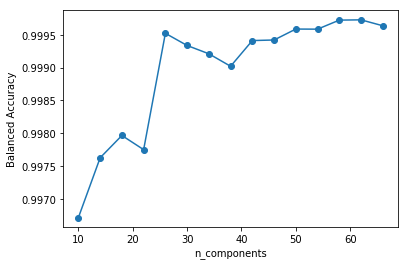

Wall time: 27min 59s


In [98]:
%%time
#Dataframe to hold the metrics
metric_df = pd.DataFrame(columns=['DBS', 'CHS', 'SS', 'BA'])
#Range for the number of clusters
size_rng = range(10,70,4)

for i in size_rng:
    metric_df.loc[len(metric_df), :] = do_clusters(x_train, cluster.OPTICS, (), {'min_samples':i}, True)

#Plots the metrics
plot_metrics(metric_df, size_rng)

# Append Cluster to Dataframe

In [99]:
#Function that appends the cluster number to the dataframe
def make_df(df, lbl, names):
    #Make a data frame with the cluster number added onto it
    the_df = pd.concat([pd.DataFrame(df), pd.DataFrame(list(lbl))], axis=1)
    names.append("Clust")
    the_df.columns = names
    the_df["Clust"] = the_df["Clust"].astype(int)
    return the_df

#### KMeans: 11

In [121]:
%%time
kmeans = KMeans(n_clusters = 11, init = 'random', n_init = 10, n_jobs = -1).fit(x_train)

#Make a data frame with the cluster number added onto it
x_train_kmeans = make_df(x_train, kmeans.labels_, list(df_zg_hot_x.columns))

Wall time: 226 ms


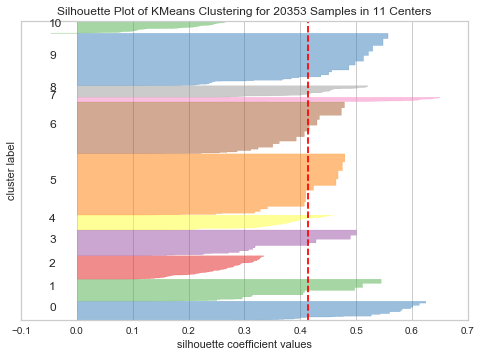

Wall time: 11.7 s


In [123]:
%%time
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(kmeans)
visualizer.fit(x_train)
visualizer.poof()

# Cluster Composition

In [124]:
import seaborn as sns
def heat_map(corr):
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True, linewidths = 0.5
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

## KMeans

#### General Correlation

In [125]:
x_train_kmeans.corr()

,age,gender,diabetesMed,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,Clust
age,1.000000,0.053175,-0.028833,0.029130,-0.017616,-0.032165,0.035637,0.024891,-0.153247,0.117261,-0.032699,-0.011849,0.060404,-0.033299,-0.039140,0.010434
gender,0.053175,1.000000,-0.024545,-0.010917,0.010707,-0.000700,0.001828,-0.007048,-0.018946,0.013171,0.007163,-0.003373,-0.005347,0.007067,0.003615,-0.026088
diabetesMed,-0.028833,-0.024545,1.000000,0.023135,0.021889,-0.009816,-0.019193,0.016636,0.081296,-0.060251,-0.012326,0.071735,-0.348318,0.261885,0.117574,0.604320
max_glu_serum_>200,0.029130,-0.010917,0.023135,1.000000,-0.014248,-0.519014,-0.020559,-0.016727,-0.026517,0.040288,-0.021401,0.001582,-0.026483,0.023245,0.009475,-0.072072
max_glu_serum_>300,-0.017616,0.010707,0.021889,-0.014248,1.000000,-0.475019,-0.018817,-0.022903,0.006429,0.022451,-0.026284,0.019300,-0.047727,-0.001641,0.058236,0.172506
max_glu_serum_None,-0.032165,-0.000700,-0.009816,-0.519014,-0.475019,1.000000,-0.685418,0.038122,0.040698,-0.071547,0.038520,0.013634,0.007155,-0.006917,-0.021464,0.101543
max_glu_serum_Norm,0.035637,0.001828,-0.019193,-0.020559,-0.018817,-0.685418,1.000000,-0.025104,-0.041866,0.054729,-0.019711,-0.034089,0.043683,-0.006850,-0.017770,-0.209876
A1Cresult_>7,0.024891,-0.007048,0.016636,-0.016727,-0.022903,0.038122,-0.025104,1.000000,-0.059195,-0.444545,-0.046162,-0.007834,0.003378,0.001187,0.003423,0.090276
A1Cresult_>8,-0.153247,-0.018946,0.081296,-0.026517,0.006429,0.040698,-0.041866,-0.059195,1.000000,-0.654229,-0.067935,0.027879,-0.100261,0.045470,0.067872,0.009895
A1Cresult_None,0.117261,0.013171,-0.060251,0.040288,0.022451,-0.071547,0.054729,-0.444545,-0.654229,1.000000,-0.510181,-0.014103,0.074380,-0.040115,-0.050200,-0.020823


In [126]:
#All correlation with Clust sorted
x_train_kmeans.corr().sort_values(by = "Clust")["Clust"]

insulin_Up           -0.421766
max_glu_serum_Norm   -0.209876
max_glu_serum_>200   -0.072072
A1Cresult_Norm       -0.056208
gender               -0.026088
A1Cresult_None       -0.020823
A1Cresult_>8          0.009895
age                   0.010434
insulin_Steady        0.045589
insulin_Down          0.071100
A1Cresult_>7          0.090276
max_glu_serum_None    0.101543
insulin_No            0.145972
max_glu_serum_>300    0.172506
diabetesMed           0.604320
Clust                 1.000000
Name: Clust, dtype: float64

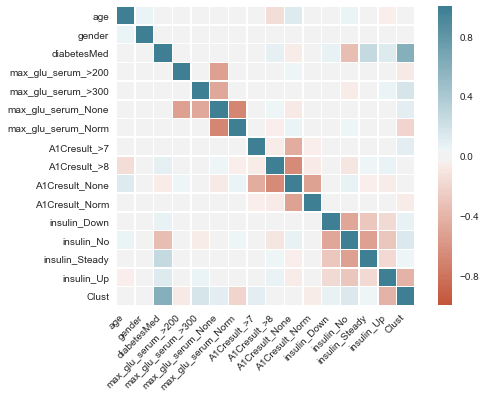

In [128]:
heat_map(x_train_kmeans.corr())

#### In Cluster Correlation

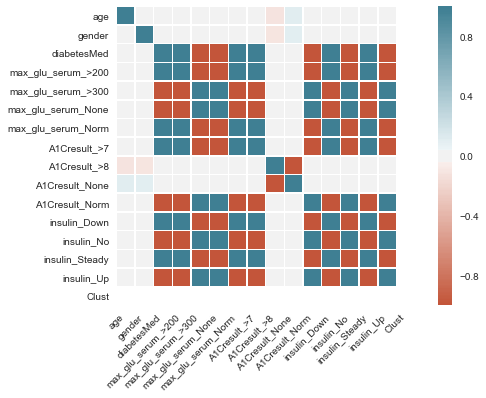

In [129]:
#0 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 0].corr())

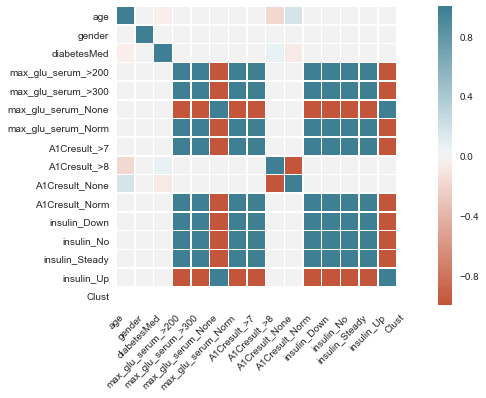

In [130]:
#1 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 1].corr())

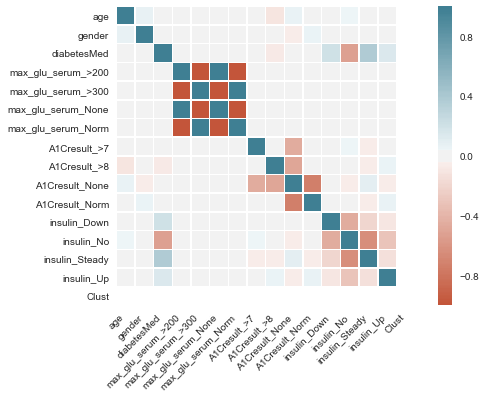

In [131]:
#2 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 2].corr())

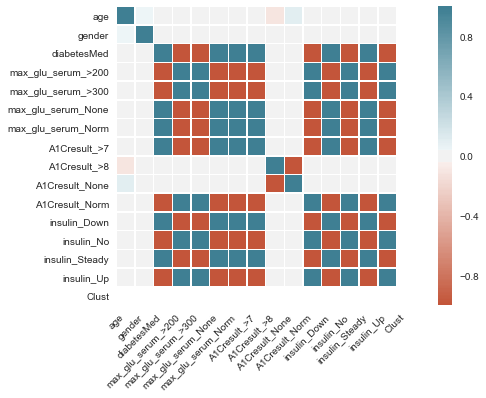

In [132]:
#3 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 3].corr())

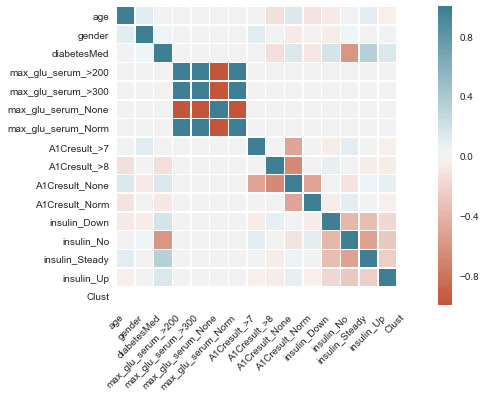

In [133]:
#4 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 4].corr())

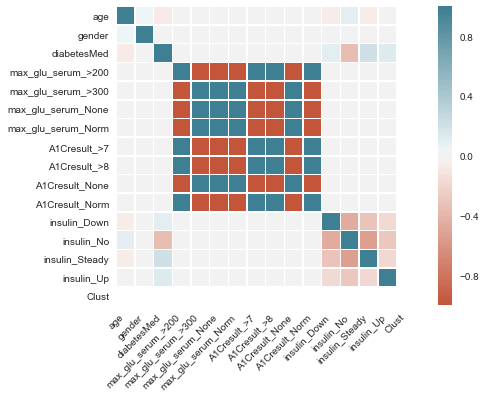

In [134]:
#5 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 5].corr())

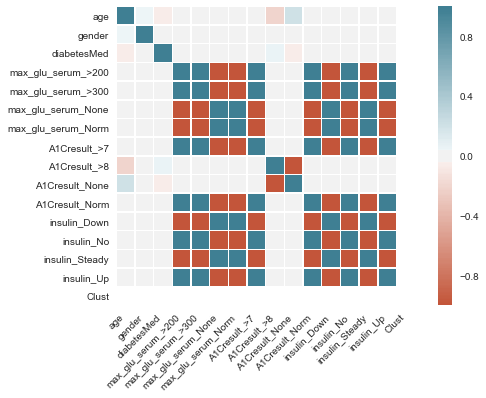

In [135]:
#6 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 6].corr())

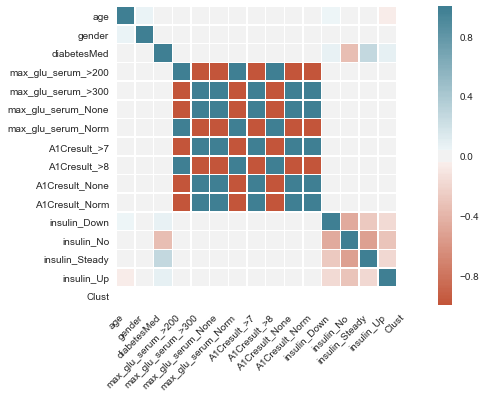

In [136]:
#7 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 7].corr())

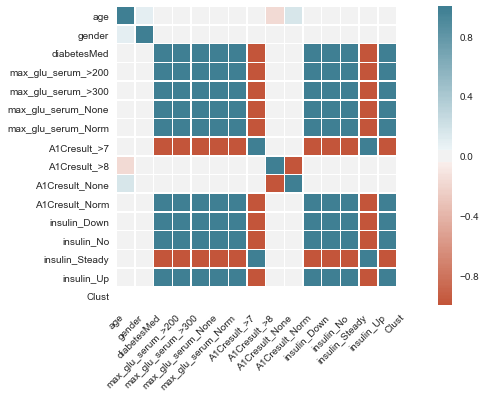

In [137]:
#8 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 8].corr())

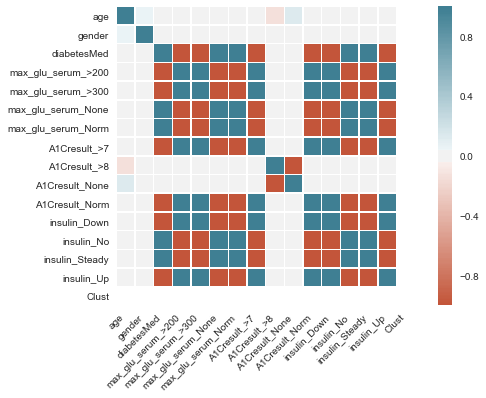

In [138]:
#9 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 9].corr())

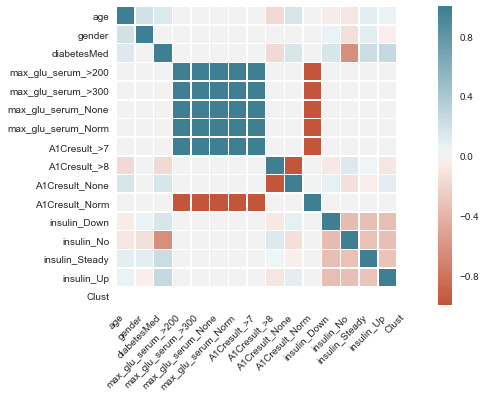

In [139]:
#10 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 10].corr())